In [5]:
import numpy
import tifffile
from pathlib import Path
import operator
import pandas
import click

In [6]:
def padding_func(vector, iaxis_pad_width, iaxis, kwargs):
    if sum(iaxis_pad_width) > 0:
        med = numpy.median(vector[iaxis_pad_width[0]:-iaxis_pad_width[1]])
        vector[:iaxis_pad_width[0]] = med
        vector[-iaxis_pad_width[1]:] = med

In [7]:
def cropND(img, bounding):

    # compute possibly necessary padding widths
    padding = tuple(map(lambda a,b: abs(min(0, b-a)), bounding, img.shape))
    if sum(padding) > 0:
      
        # split padding into before and after part
        before_after = tuple(map(lambda a: (a//2, (a//2)+(a%2)), padding))
        img = numpy.pad(
            array=img,
            pad_width=before_after,
            mode=padding_func
        )
        
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [8]:
def make_meta():
    pathname = "/user/gent/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2"
    # pathname = "/data/Experiment_data/weizmann/EhV/v2"
    tile_output = Path("/user/gent/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/tiles/")
    data = []

    ch1 = sorted(list(Path(tile_output).glob("{Ctrl,Inf}_T*_R1/*Ch1.tiff")))
    ch4 = sorted(list(Path(tile_output).glob("{Ctrl,Inf}_T*_R1/*Ch3.tiff")))
    # ch6 = sorted(list(Path(tile_output).glob("Inf_T*_R1/*Ch6.tiff")))
    ch7 = sorted(list(Path(tile_output).glob("{Ctrl,Inf}_T*_R1/*Ch7.tiff")))
    # ch11 = sorted(list(Path(tile_output).glob("Inf_T*_R1/*Ch11.tiff")))

    for p1, p4, p7 in zip(ch1, ch4, ch7):
        out = {
            "Image_FileName_1": str(p1.relative_to(p1.parents[2])),
            "Image_PathName_1": pathname,
            "Image_FileName_3": str(p4.relative_to(p4.parents[2])),
            "Image_PathName_3": pathname,
            "Image_FileName_7": str(p7.relative_to(p7.parents[2])),
            "Image_PathName_7": pathname,
        }
        data.append(out)

    pandas.DataFrame(data)[["Image_FileName_1", "Image_PathName_1", "Image_FileName_3", "Image_PathName_3", "Image_FileName_7", "Image_PathName_7"]].to_csv(str(tile_output.parent / "metadata.csv"), index=False)

In [9]:
make_meta()

KeyError: "None of [Index(['Image_FileName_1', 'Image_PathName_1', 'Image_FileName_3',\n       'Image_PathName_3', 'Image_FileName_7', 'Image_PathName_7'],\n      dtype='object')] are in the [columns]"

In [6]:
@click.command()
@click.argument("part", type=str)
def main(part):
    images = list(Path("/user/gent/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/high_time_res/High/images/").glob(f"{part}/*Ch1.*.tif"))
    tile_output = Path("/user/gent/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/high_time_res/High/tiles/")

    ncols = 10
    nrows = 20
    ntiles = (len(images) // (ncols*nrows)) + ((len(images) % (ncols*nrows)) != 0)
    channels = [1, 4, 6, 7, 11]
    bounding = len(channels), 48, 48
    
    print(f"Writing {ntiles} tiles for {len(images)} images")

    for i in range(ntiles):
        tile = numpy.zeros(shape=(bounding[0], bounding[1]*nrows, bounding[2]*ncols), dtype=float)

        start = i * (ncols * nrows)
        end = (i + 1) * (ncols * nrows)
        for j, image in enumerate(images[start:end]):
            paths = [
                image.parent / image.name.replace("Ch1", "Ch"+str(c))
                for c in channels
            ]
          
            missing = False
            for p in paths:
                if not p.exists():
                    print(f"{str(p)} is missing")
                    missing = True
          
            if not missing:
                row = j // ncols
                col = j % ncols
                pixels = cropND(tifffile.imread(paths), bounding)

                tile[
                    :,
                    row*bounding[1]:(row+1)*bounding[1],
                    col*bounding[2]:(col+1)*bounding[2]
                ] = pixels

        (tile_output /  part).mkdir(exist_ok=True)
        for j, t in enumerate(tile):
            tifffile.imwrite(str(tile_output / part / f"{i}_Ch{channels[j]}.tiff"), t, photometric="minisblack")

In [14]:
if __name__ == "__main__":
    main()

Usage: ipykernel_launcher.py [OPTIONS] PART
Try 'ipykernel_launcher.py --help' for help.

Error: No such option: -f
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/scratch/leuven/420/vsc42015/miniconda3/envs/cp/lib/python3.8/site-packages/click/parser.py", line 514, in _process_opts
    self._match_long_opt(norm_long_opt, explicit_value, state)
  File "/scratch/leuven/420/vsc42015/miniconda3/envs/cp/lib/python3.8/site-packages/click/parser.py", line 398, in _match_long_opt
    raise NoSuchOption(opt, possibilities=possibilities, ctx=self.ctx)
click.exceptions.NoSuchOption: No such option: -f

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/scratch/leuven/420/vsc42015/miniconda3/envs/cp/lib/python3.8/site-packages/click/core.py", line 1052, in main
    with self.make_context(prog_name, args, **extra) as ctx:
  File "/scratch/leuven/420/vsc42015/miniconda3/envs/cp/lib/python3.8/site-packages/click/core.py", line 914, in make_context
    self.parse_args(ctx, args)
  File "/scratch/leuven/420/vsc42015/miniconda3/envs/cp/lib/python3.8/site-pack

TypeError: object of type 'NoneType' has no len()

In [2]:
import matplotlib.pyplot as plt

In [22]:
im = tifffile.imread("/user/gent/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/tiles/Inf_T0_R1/0_Ch3.tiff")

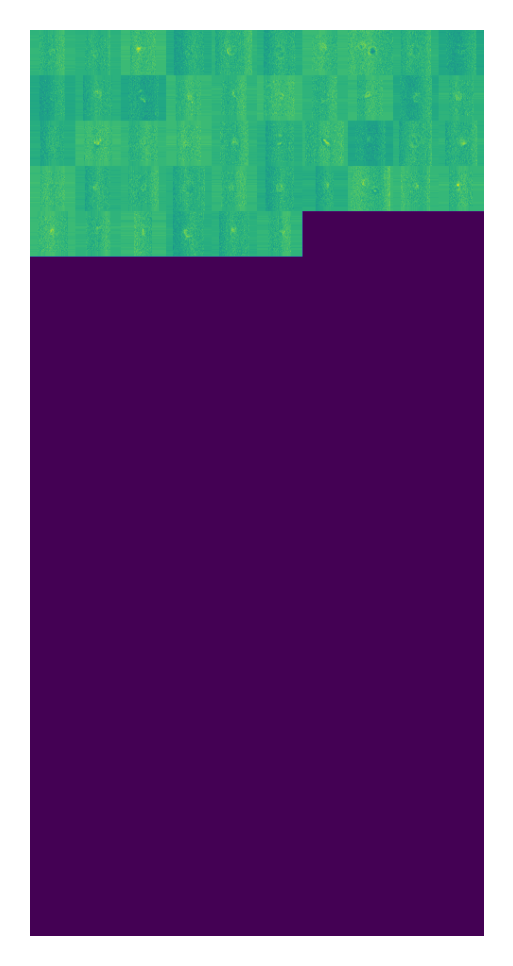

In [23]:
fig, ax = plt.subplots(dpi=300)
ax.set_axis_off()
ax.imshow(im)